In [1]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190723.tar.gz -C ../raw_data

In [2]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190723"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)

pd.set_option('display.max_rows', 90)
# print(df)

In [3]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

# print(samples)

In [4]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)

                           sample  N2O_peak  CO2_peak  CH4_peak        ppm
3    CH4Std_100ppm_7232019_47.txt     50209   1471811    106072    100.000
4     CH4Std_10ppm_7232019_19.txt     19543   2266994     23309     10.000
5      CH4Std_2ppm_7232019_18.txt     20006    206893    147716      2.000
6   CH4Std_5030ppm_7232019_48.txt     18221    420016  10263645   5030.000
7   CO2Std_10100ppm_7232019_7.txt     14680  21968210         0  10100.000
8   CO2Std_1010ppm_7232019_31.txt     20121   2395102         0   1010.000
9   CO2Std_50000ppm_7232019_8.txt     15602  82991503         0  50000.000
10   CO2Std_500ppm_7232019_30.txt     15763   1273300         0    500.000
57   N2OStd_0101ppm_7232019_1.txt     41674    391970      2505      0.101
58     N2OStd_05ppm_7232019_2.txt     90439    254723      2732      0.500
59     N2OStd_10ppm_7232019_9.txt    946096    505643         0     10.000
60      N2OStd_1ppm_7232019_3.txt    219794    125441         0      1.000
61    N2OStd_80ppm_723201

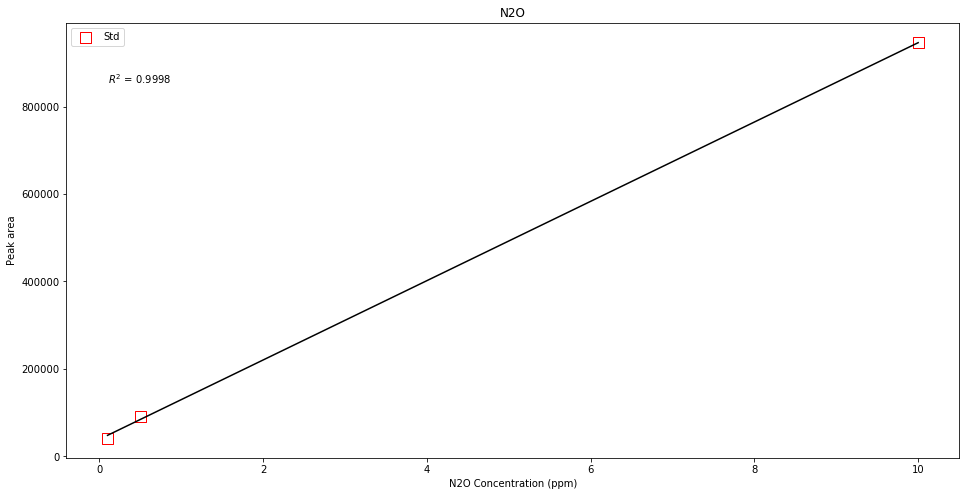

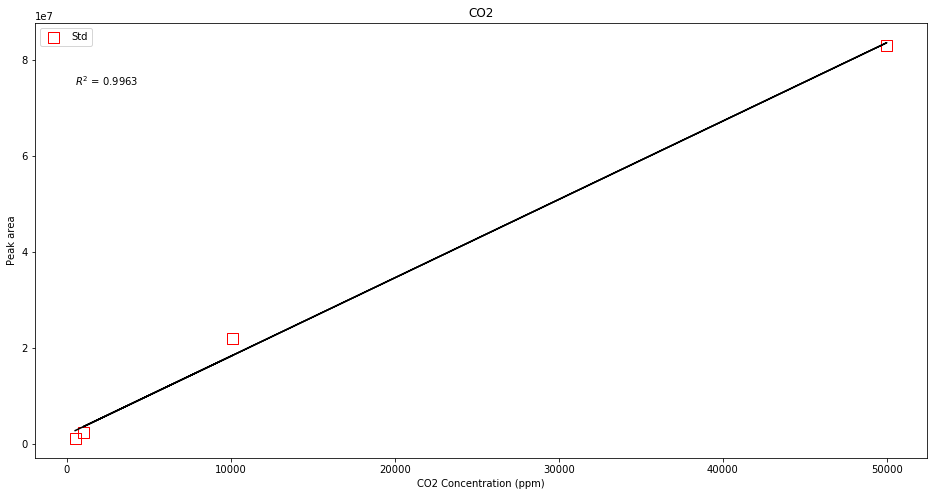

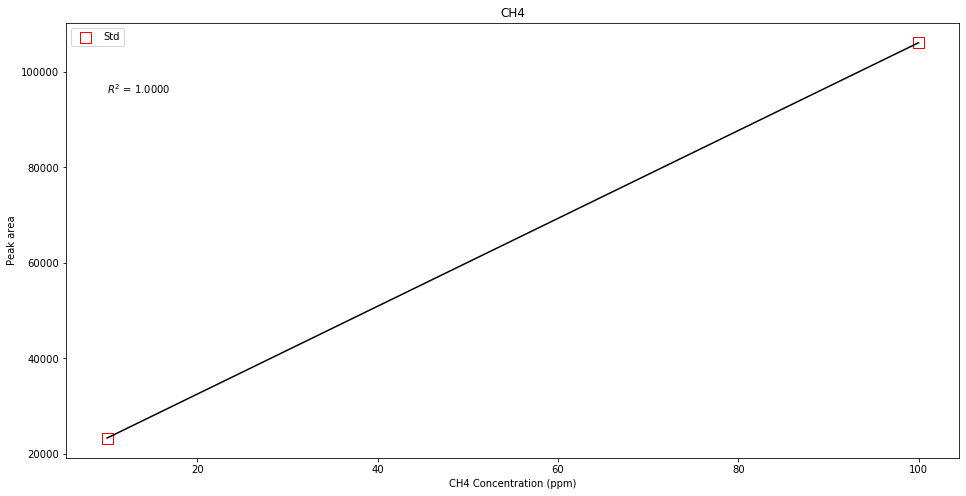

In [5]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Play around with CH4 standard curve
CH4std = CH4std[~CH4std['sample'].str.contains('5030ppm')] # Drop 5000 ppm since no samples are above 10 ppm
CH4std = CH4std[~CH4std['sample'].str.contains('_2ppm')] # 2ppm looks absurdly high

# Play around with N2O standard curve 
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_80ppm')] # Drop 80 ppm since no samples are above 10 ppm
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_1ppm')] # Drop 1 ppm as well -- it looks high

# Play around with CO2 standard curve

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],"N2O")
plot_standards(CO2std['ppm'],CO2std['CO2_peak'],"CO2")
plot_standards(CH4std['ppm'],CH4std['CH4_peak'],"CH4")

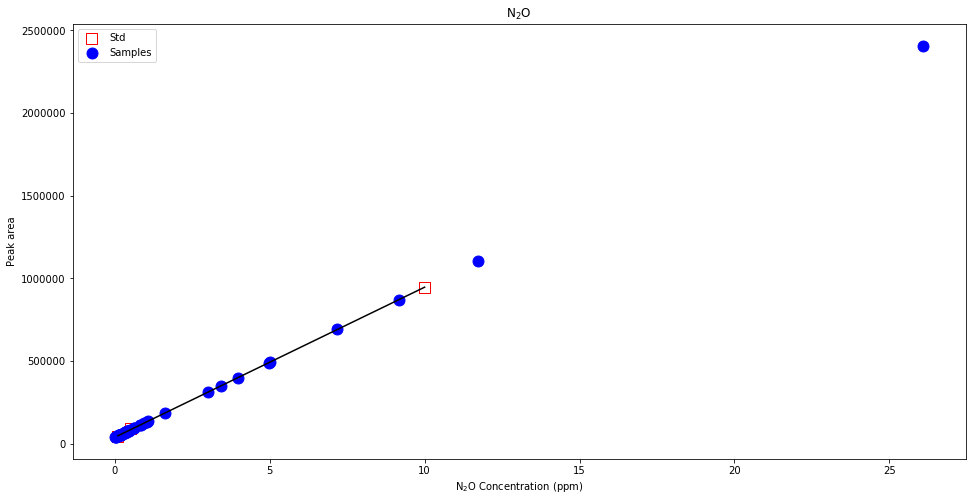

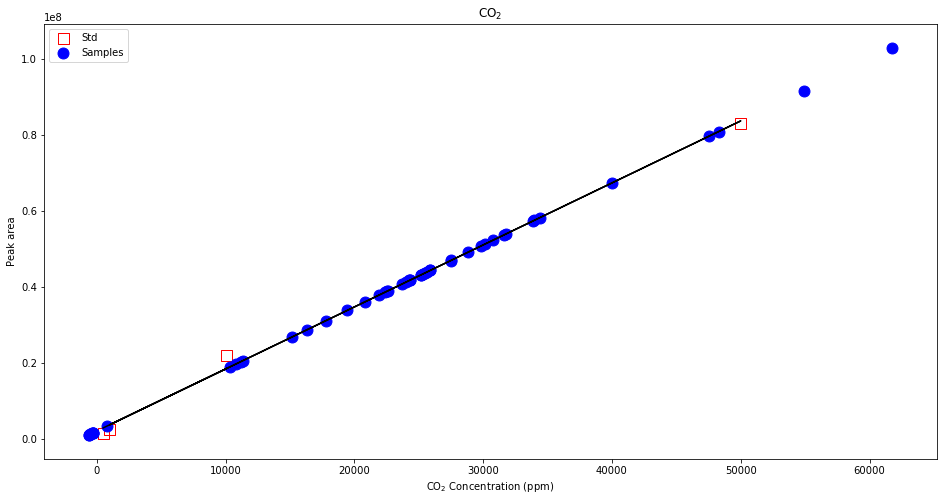

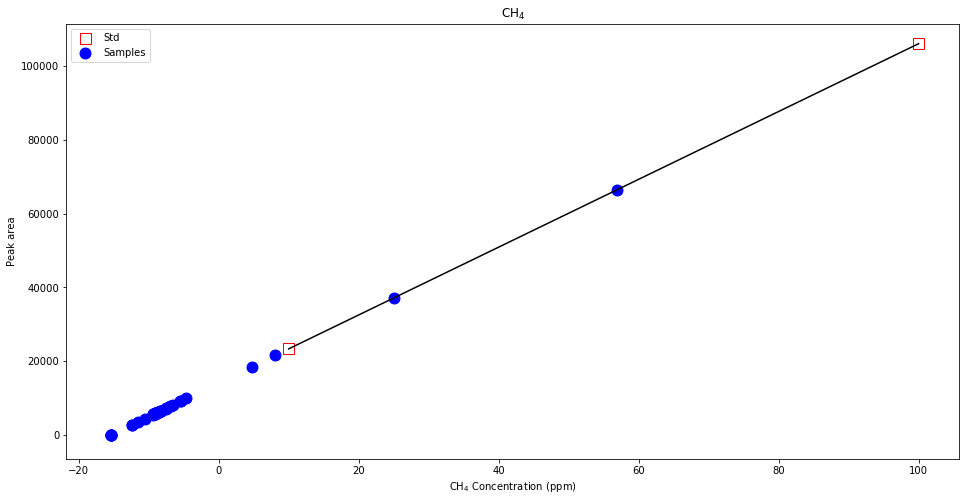

In [6]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], r"N$_2$O")
plot_samples(samples['CO2_peak'], CO2std['ppm'], CO2std['CO2_peak'], r"CO$_2$")
plot_samples(samples['CH4_peak'], CH4std['ppm'], CH4std['CH4_peak'], "CH$_4$")

In [7]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190723.txt", 
                                 write_to_datafile=False)

# Correct for single high sample (PTT1-60cm; vial 62) now that we've 
# removed 80 ppm standard. Calculated N2O was 51.292233 ppm with the 
# 80ppm standard included in the standard curve
i = saveoutput.index[saveoutput['vial'] == '62']
saveoutput.loc[i, 'N2O_conc'] = 33.316307

print(saveoutput)
saveoutput.to_csv("../processed_data/RVT_TracerTest_GasConcentrations_20190723.txt", mode='w', sep="\t", index=False, header=False, na_rep='NaN')

   vial    location depth       date method    dup   N2O_conc  N2O_bdl  \
0    16        NTT1    90 2019-07-01      H  False   0.959146    False   
1    24        PTC1   150 2019-06-24      H  False   0.107425    False   
2    36        PTT0   150 2019-06-24      H  False   0.115523    False   
11   52  Atmosphere     0 2019-06-24      G  False   0.306047    False   
12   17  Atmosphere     0 2019-07-01      H  False   0.305353    False   
13   14        NTT1    30 2019-07-01      G  False   0.498864    False   
14   15        NTT1    60 2019-07-01      G  False  11.734013    False   
15    4        Pit1   115 2019-07-01      G  False   0.382306    False   
16    5        Pit1   170 2019-07-01      H  False   0.123289    False   
17    6        Pit1   210 2019-07-01      H  False   0.149245    False   
18   54        Pit2   117 2019-06-12      H  False   0.186945    False   
19   12        Pit2   117 2019-07-01      H  False   0.050500     True   
20   55        Pit2   155 2019-06-12  